### Table of Contents
* [Libraries](#Libraries)
* [Dataset](#Dataset)
* [Null Values](#Null-Values)
* [Preprocessing](#PreProcessing)
* [1. User Overiew Analysis](#1.-User-Overiew-Analysis)
    * [User Aggregates](#Aggregate-per-user-the-following-information-in-the-column:)
    * [Non-Graphical Univariate Analysis](#Non-Graphical-Univariate-Analysis)
    * [Graphical Univariate Analysis.](#Graphical-Univariate-Analysis.)
    * [Bivariate Analysis](#Bivariate-Analysis)
    * [Variable Transformation](#Variable-transformations)
    * [Correlation Analysis](#Correlation-Analysis)
    * [Dimensionality Reduction](#Dimensionality-Reduction)

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


import warnings
warnings.filterwarnings(action="ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/Week2_challenge_data_source.xlsx


## Dataset

In [2]:
raw = pd.read_excel('/kaggle/input/Week2_challenge_data_source.xlsx')
raw.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [3]:
raw.shape

(150001, 55)

Quite a bulk dataset.

## PreProcessing

### Numerical, Categorical and TimeStamp features

In [4]:
numerical = []
categorical = []
timestamps = []

for col in raw.columns:
    if raw[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical.append(col)
    elif raw[col].dtype == object:
        categorical.append(col)
    else:
        timestamps.append(col)
        
        
features = numerical+categorical+timestamps
data = raw[features]
data.head(3)

,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),...,Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Bearer Id,Last Location Name,Handset Manufacturer,Handset Type,Start,End
0,770.0,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,42.0,5.0,23.0,44.0,...,171744450.0,8814393.0,36749741.0,308879636.0,13114483460844900352,9164566995485190,Samsung,Samsung Galaxy A5 Sm-A520F,2019-04-04 12:01:18,2019-04-25 14:35:31
1,235.0,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.0,5.0,16.0,26.0,...,526904238.0,15055145.0,53800391.0,653384965.0,13114483482878900224,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530),2019-04-09 13:04:04,2019-04-25 08:15:48
2,1.0,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,NaN,NaN,6.0,9.0,...,410692588.0,4215763.0,27883638.0,279807335.0,13114483484080500736,D42335A,Samsung,Samsung Galaxy A8 (2018),2019-04-09 17:42:11,2019-04-25 11:58:13


In [5]:
data.shape

(150001, 55)

### Null Values

#### Numerical Cols

In [6]:
#Null numerical values (percentage)
null = data[numerical].isna().sum().sort_values(ascending = False)
null_per = (null/150001) * 100
null_perc = pd.DataFrame(null_per)
null_perc.head(10)

,0
Nb of sec with 37500B < Vol UL,86.835421
Nb of sec with 6250B < Vol UL < 37500B,74.561503
Nb of sec with 125000B < Vol DL,65.024900
TCP UL Retrans. Vol (Bytes),64.432237
Nb of sec with 31250B < Vol DL < 125000B,62.390251
Nb of sec with 1250B < Vol UL < 6250B,61.928920
Nb of sec with 6250B < Vol DL < 31250B,58.877607
TCP DL Retrans. Vol (Bytes),58.763608
HTTP UL (Bytes),54.539636
HTTP DL (Bytes),54.315638


Some columns have big percentages of missing values. For the meantime, imputation with column means will be done incase the columns come in handy. Otherwise, they'll be dropped. The **big_data** list below will store the names of cols with missing values > 50%

In [7]:
# columns with >50% null values
bad_data = []
for entry, column in zip(null_perc.iloc[:, 0], null_perc.index):
    if entry >= 50:
        bad_data.append(column)
        
# bad_data

All the numerical columns with missing values will be imputed with the mean of the column given the absence of nominal columns.

In [8]:
# get the numerical null values indices from the dataframe
a = null_perc.index.to_list()
# col_index = pd.DataFrame(raw.columns, columns = ['name'])
indices = []
for col in a:
    k = data.columns.get_loc(col)
    indices.append(k)
# col_index
len(indices)

49

In [9]:
#imputing with column means.
columns = indices
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    data.iloc[:, col] = x    

In [10]:
data[numerical].isna().any()

Start ms                                    False
End ms                                      False
Dur. (ms)                                   False
IMSI                                        False
MSISDN/Number                               False
IMEI                                        False
Avg RTT DL (ms)                             False
Avg RTT UL (ms)                             False
Avg Bearer TP DL (kbps)                     False
Avg Bearer TP UL (kbps)                     False
TCP DL Retrans. Vol (Bytes)                 False
TCP UL Retrans. Vol (Bytes)                 False
DL TP < 50 Kbps (%)                         False
50 Kbps < DL TP < 250 Kbps (%)              False
250 Kbps < DL TP < 1 Mbps (%)               False
DL TP > 1 Mbps (%)                          False
UL TP < 10 Kbps (%)                         False
10 Kbps < UL TP < 50 Kbps (%)               False
50 Kbps < UL TP < 300 Kbps (%)              False
UL TP > 300 Kbps (%)                        False


#### Categorical and Timestamp cols

In [11]:
#Null categorical and timestamps values 
null = data[categorical + timestamps].isna().sum().sort_values(ascending = False)
null = (null/150001) * 100
null = pd.DataFrame(null)
null

,0
Last Location Name,0.768662
Handset Type,0.381331
Handset Manufacturer,0.381331
End,0.000667
Start,0.000667
Bearer Id,0.000000


The null values in these columns contribute a small percentage to the column values, thus not  a big deal. Imputation will be done using the mode/most_frequent value. But first, they have to be converted to type **str**.

In [12]:
for col in categorical+timestamps:
    data[col] = data[col].astype(str)

In [13]:
# get the numerical null values indices from the dataframe
a = null.index.to_list()
# col_index = pd.DataFrame(raw.columns, columns = ['name'])
indices = []
for col in a:
    k = data.columns.get_loc(col)
    indices.append(k)
    
indices

[50, 52, 51, 54, 53, 49]

In [14]:
# imputing with mode
columns = indices
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    data.iloc[:, col] = x   

In [15]:
data[categorical+timestamps].isna().any()

Bearer Id               False
Last Location Name      False
Handset Manufacturer    False
Handset Type            False
Start                   False
End                     False
dtype: bool

All null values taken care of.

### Timestamps to Pandas Datetime object
For imputation to work, their data type had to be change to string. That has to be reversed.

In [16]:
data['Start'] = pd.to_datetime(data['Start'])
data['End'] = pd.to_datetime(data['End'])

### Feature Generation

In [17]:
data['total_bytes'] =  data['Total UL (Bytes)'] + data['Total DL (Bytes)']
data['social_media'] = data['Social Media DL (Bytes)'] + data['Social Media UL (Bytes)']
data['email'] = data['Email DL (Bytes)'] + data['Email UL (Bytes)']
data['google'] = data['Google DL (Bytes)'] + data['Google UL (Bytes)']
data['youtube'] = data['Youtube DL (Bytes)'] + data['Youtube UL (Bytes)']
data['netflix'] = data['Netflix UL (Bytes)'] + data['Netflix DL (Bytes)']
data['gaming'] = data['Gaming DL (Bytes)'] + data['Gaming UL (Bytes)']
data['other'] = data['Other DL (Bytes)'] + data['Other UL (Bytes)']

### Encoding Categorical columns

The method pd.get_dummies() encodes categorical variables using the OneHotEncoder method which is preferred over the LabelEncoder. The latter assigns numerical valuesm to the variable's values hierarchically. This will result to biased data since some entries could be perceived as having more weight than others when the only difference is class type.
Despite the preference of OHE  over LE, the dataset is already big, encoding it with OHE would increase it's size at least twice. Due to computational limitations (memory allocation), LE is used. But always, OHE is a better performer.

In [18]:
# enc_data = pd.get_dummies(data).reset_index(drop=True)
# enc_data.shape
data[categorical].head(3)

,Bearer Id,Last Location Name,Handset Manufacturer,Handset Type
0,13114483460844900352,9164566995485190,Samsung,Samsung Galaxy A5 Sm-A520F
1,13114483482878900224,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530)
2,13114483484080500736,D42335A,Samsung,Samsung Galaxy A8 (2018)


In [19]:
columns = [50, 52, 51, 49]
for col in columns:
    x = data.iloc[:, col].values
    x = x.reshape(-1,1)
    encoder = LabelEncoder()
    encoder = encoder.fit(x)
    x = encoder.transform(x)
    name = data.columns[col]
    data[name + '_encoded'] = x   # create new columns with the encoded values instead of replacing them, might come in handy at later stages

## 1. User Overiew Analysis

### Top 10 handsets

In [20]:
top_10_sets = data['Handset Type'].value_counts(ascending = False).head(10)
top_10_sets = pd.DataFrame(top_10_sets)
top_10_sets

,Handset Type
Huawei B528S-23A,19752
Apple iPhone 6S (A1688),9419
Apple iPhone 6 (A1586),9023
undefined,8987
Apple iPhone 7 (A1778),6326
Apple iPhone Se (A1723),5187
Apple iPhone 8 (A1905),4993
Apple iPhone Xr (A2105),4568
Samsung Galaxy S8 (Sm-G950F),4520
Apple iPhone X (A1901),3813


Text(0.5, 1.0, 'A barplot indicating top ten handset types')

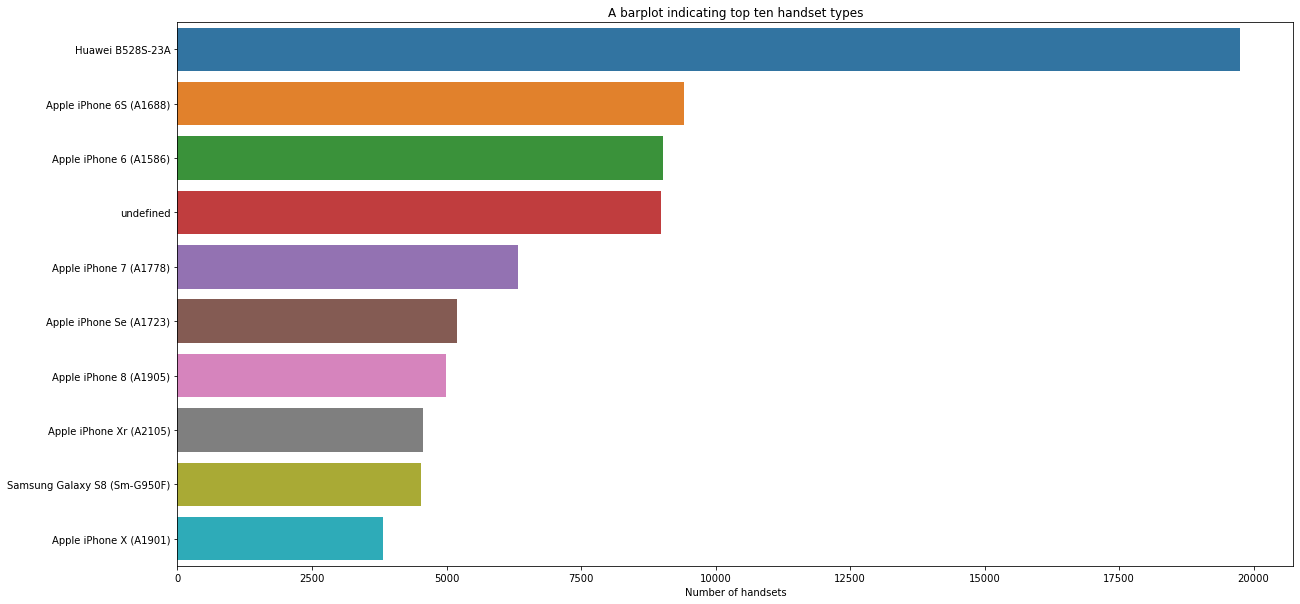

In [21]:
plt.figure(figsize=(20,10))
sns.barplot(y = top_10_sets.index, x = top_10_sets['Handset Type'])
plt.xlabel('Number of handsets')
plt.title('A barplot indicating top ten handset types')

### Bottom 10 handsets

Text(0.5, 1.0, 'A barplot indicating bottom ten handset types')

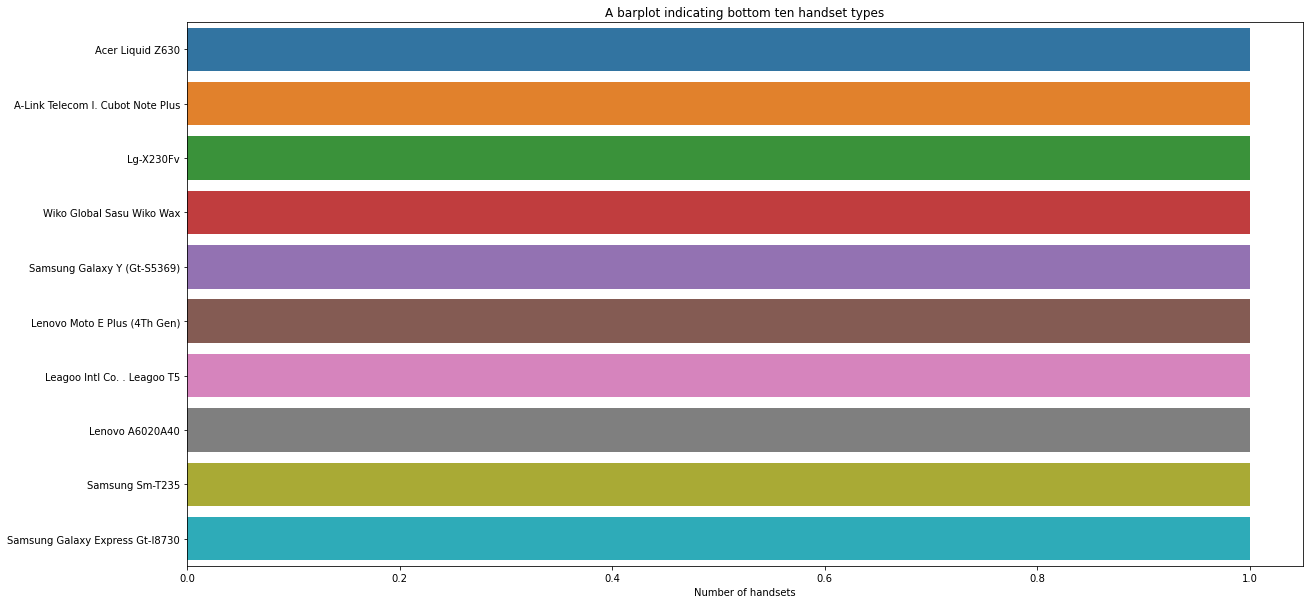

In [22]:
b_10 = data['Handset Type'].value_counts(ascending = False).tail(10)
b_10 = pd.DataFrame(b_10)

plt.figure(figsize=(20,10))
sns.barplot(y = b_10.index, x = b_10['Handset Type'])
plt.xlabel('Number of handsets')
plt.title('A barplot indicating bottom ten handset types')

### top 3 handset manufacturers

In [23]:
top_3_manufacturers = data['Handset Manufacturer'].value_counts(ascending = False).head(3)
top_3_manufacturers = pd.DataFrame(top_3_manufacturers)
top_3_manufacturers

,Handset Manufacturer
Apple,59565
Samsung,40839
Huawei,34423


Text(0.5, 1.0, 'A barplot indicating top 3 handset manufacturers')

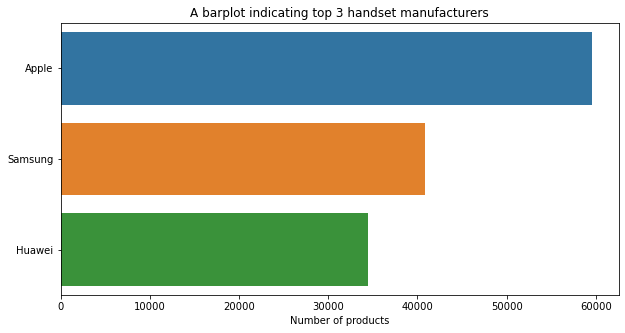

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(y = top_3_manufacturers.index, x = top_3_manufacturers['Handset Manufacturer'])
plt.xlabel('Number of products')
plt.title('A barplot indicating top 3 handset manufacturers')

### Bottom 3 manufacturers

Text(0.5, 1.0, 'A barplot indicating bottom 3 handset manufacturers')

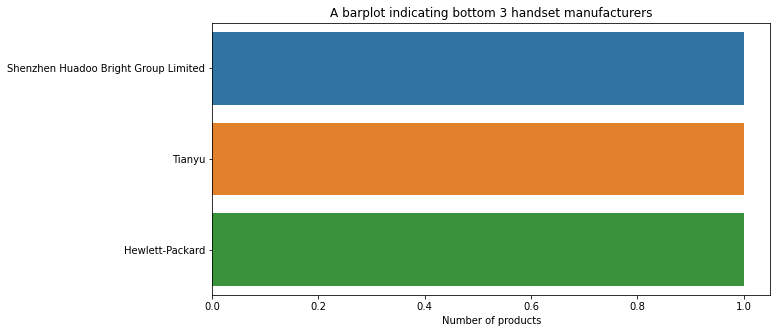

In [25]:
b3 = data['Handset Manufacturer'].value_counts(ascending = False).tail(3)
b3 = pd.DataFrame(b3)

plt.figure(figsize=(10,5))
sns.barplot(y = b3.index, x = b3['Handset Manufacturer'])
plt.xlabel('Number of products')
plt.title('A barplot indicating bottom 3 handset manufacturers')

###  top 5 handsets per handset manufacturer

In [26]:
a = data.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name = 'count').sort_values(['Handset Manufacturer', 'count'], ascending = False).groupby('Handset Manufacturer').head(5)
a.tail(20)

,Handset Manufacturer,Handset Type,count
66,Apple,Apple iPhone 7 (A1778),6326
80,Apple,Apple iPhone Se (A1723),5187
73,Apple,Apple iPhone 8 (A1905),4993
24,Alif Communications,Alif Communicati. Pulian Cm84,1
23,Adar,Adar Stanley Mobile S231,1
20,Acer,Acer M310,5
19,Acer,Acer Liquid Zest Plus,2
14,Acer,Acer Liquid M220,1
15,Acer,Acer Liquid Z220,1
16,Acer,Acer Liquid Z530,1


In [27]:
# data.groupby(["Handset Manufacturer", 'Handset Type'])['Handset Type'].count().reset_index(name='Count')
# b = pd.DataFrame(data.groupby(['Handset Manufacturer', 'Handset Type']).size()).groupby('Handset Manufacturer')
# b = b.apply(lambda _df: _df.sort_values(by=['Handset Manufacturer'], ascending = False))
# b.head(20)
# data[data['Handset Type'] == 'Apple iPhone 7 (A1778)'].shape

In [28]:
# data.groupby('Handset Manufacturer')['Handset Type'].value_counts().unstack(0).plot.barh()

### Make a short interpretation and recommendation to marketing teams

* Apple, Huawei and Samsung are the leading manufacturers. The top 10 handsets also are manufactured by these companies. Some of the bottom 10 handsets also belong to these manufacturers. Thus the volume of the most common handsets should be increased to replace the least common sets. 
* Products from the bottom 3 manufacturers should no longer be stocked. Their extremely small volume matches small profit percentage in comparison to other manufacturers.

### Aggregate per user the following information in the column:

1.  number of xDR sessions

In [29]:
xdr_sess = data[['Bearer Id', 'MSISDN/Number']]
a = xdr_sess.groupby('MSISDN/Number').count()
a.columns = ['xdr sessions']
a.head()

,xdr sessions
MSISDN/Number,
3.360100e+10,1
3.360100e+10,1
3.360100e+10,1
3.360101e+10,1
3.360101e+10,2


Text(0.5, 1.0, 'users with highest session numbers')

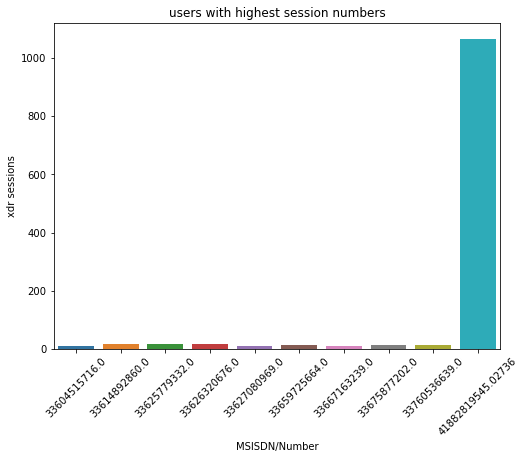

In [30]:
t = a.sort_values(by = 'xdr sessions', ascending = False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x = t.index, y = t['xdr sessions'])
plt.xticks(rotation = 45)
plt.title('users with highest session numbers')

2.  Session duration

In [31]:
duration = data[['Dur. (ms)', 'MSISDN/Number']]
b = duration.groupby('MSISDN/Number').sum()
b.columns = ['sess_duration (ms)']
b.head()

,sess_duration (ms)
MSISDN/Number,
3.360100e+10,116720.0
3.360100e+10,181230.0
3.360100e+10,134969.0
3.360101e+10,49878.0
3.360101e+10,37104.0


Text(0.5, 1.0, 'users with longest session duration')

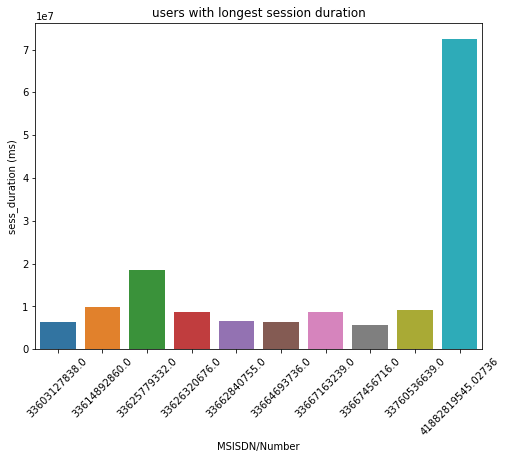

In [32]:
t = b.sort_values(by = 'sess_duration (ms)', ascending = False).head(10)
plt.figure(figsize=(8,6))
sns.barplot(x = t.index, y = t['sess_duration (ms)'])
plt.xticks(rotation = 45)
plt.title('users with longest session duration')

3. The total download (DL) and upload (UL) data

In [33]:
byte = data[['MSISDN/Number', 'Total UL (Bytes)', 'Total DL (Bytes)', 'total_bytes']]
c = byte.groupby('MSISDN/Number').sum()
c.head()

,Total UL (Bytes),Total DL (Bytes),total_bytes
MSISDN/Number,,,
3.360100e+10,36053108.0,8.426375e+08,8.786906e+08
3.360100e+10,36104459.0,1.207552e+08,1.568596e+08
3.360100e+10,39306820.0,5.566597e+08,5.959665e+08
3.360101e+10,20327526.0,4.019932e+08,4.223207e+08
3.360101e+10,94280527.0,1.363130e+09,1.457411e+09


Text(0.5, 1.0, 'A sample of users upload, download and total bytes')

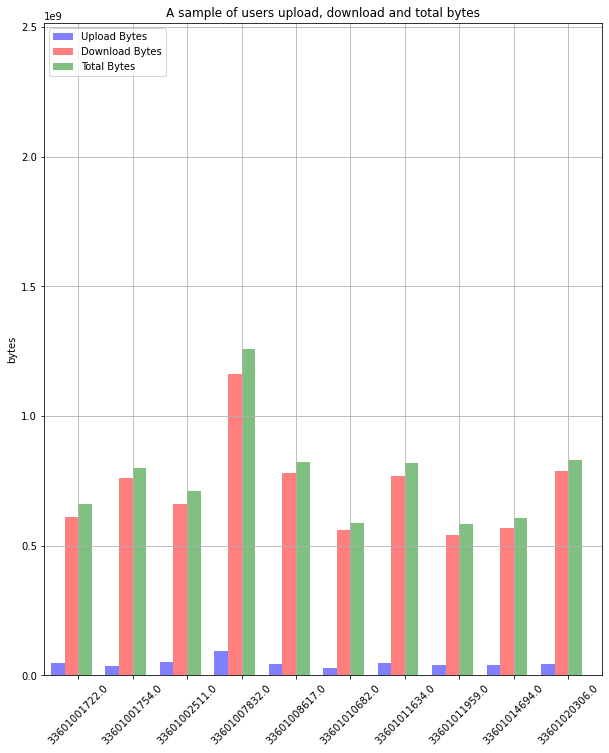

In [34]:
# plotting a sample of the data
t = c.sample(10)
pos = list(range(len(t['Total UL (Bytes)'])))
width = 0.25
fig, ax = plt.subplots(figsize=(10,12))
plt.bar(pos, t['Total UL (Bytes)'], width, alpha=0.5, color='b')
plt.bar([p + width for p in pos], t['Total DL (Bytes)'], width, alpha=0.5, color='r')
plt.bar([p + width*2 for p in pos], t['total_bytes'], width, alpha=0.5, color='g')
ax.set_ylabel('bytes')
ax.set_title('Bytes data per user')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(c.index)
plt.xticks(rotation = 45)

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(t['Total UL (Bytes)'] + t['Total DL (Bytes)'] + t['total_bytes'])] )
plt.legend(['Upload Bytes', 'Download Bytes', 'Total Bytes'], loc='upper left')
plt.grid()
plt.title('A sample of users upload, download and total bytes')

Upload bytes are less than download bytes.

4. The total data volume (in Bytes) during this session for each application

In [35]:
# I had already created total bytes columns for all the applications.
apps = data[['MSISDN/Number','social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other']]
d = apps.groupby('MSISDN/Number').sum()
d.head()

,social_media,google,email,youtube,netflix,gaming,other
MSISDN/Number,,,,,,,
3.360100e+10,2232135.0,4389005.0,1331362.0,21624548.0,27180981.0,8.124587e+08,386570872.0
3.360100e+10,2660565.0,5334863.0,3307781.0,12432223.0,11221763.0,1.197501e+08,281710071.0
3.360100e+10,3195623.0,3443126.0,3205380.0,21333570.0,19353900.0,5.388277e+08,501693672.0
3.360101e+10,280294.0,9678493.0,2284670.0,6977321.0,1942092.0,3.911261e+08,35279702.0
3.360101e+10,2912542.0,18499616.0,3305469.0,41533002.0,49201724.0,1.314798e+09,804804484.0


In [36]:
# sns.barplot(x=d.index.head(), y=, hue='variable', data=df1)
# plt.xticks(rotation=90)
# plt.ylabel('Returns')
# plt.title('Portfolio vs Benchmark Returns');

## Non-Graphical Univariate Analysis

Variables of interest: Number of xDR sessions,  Session duration,  the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).

### Dispersion and Central Tendency

In [37]:
data.describe()

,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),...,email,google,youtube,netflix,gaming,other,Last Location Name_encoded,Handset Type_encoded,Handset Manufacturer_encoded,Bearer Id_encoded
count,150001.000000,150001.000000,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,150001.000000,150001.000000,150001.000000,150001.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,150001.000000,150001.000000,150001.000000,150001.000000
mean,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,1770.428647,...,2.259102e+06,7.807295e+06,2.264348e+07,2.262861e+07,4.303331e+08,4.293653e+08,20292.245385,474.000153,56.709102,64121.558930
std,288.610872,288.096693,8.103735e+04,2.144722e+10,2.438731e+12,2.237359e+13,559.342620,76.529933,23971.798635,4625.340082,...,1.071109e+06,3.516420e+06,9.246800e+06,9.260820e+06,2.440199e+08,2.432681e+08,12892.829812,437.009646,51.461184,39291.948357
min,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,0.000000,...,8.359000e+03,4.033000e+04,7.890300e+04,9.843200e+04,3.063580e+05,1.490450e+05,0.000000,0.000000,0.000000,0.000000
25%,250.000000,251.000000,5.744200e+04,2.082014e+14,3.365151e+10,3.546261e+13,35.000000,3.000000,43.000000,47.000000,...,1.359344e+06,4.943599e+06,1.599846e+07,1.597946e+07,2.187279e+08,2.185534e+08,9185.000000,66.000000,5.000000,29222.000000
50%,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366380e+10,3.572241e+13,54.000000,7.000000,63.000000,63.000000,...,2.263567e+06,7.812835e+06,2.266177e+07,2.263554e+07,4.316150e+08,4.299865e+08,17836.000000,316.000000,52.000000,61730.000000
75%,749.000000,750.000000,1.324300e+05,2.082018e+14,3.368473e+10,8.611970e+13,109.795706,17.662883,19710.000000,1120.000000,...,3.159818e+06,1.068280e+07,2.929260e+07,2.929044e+07,6.414159e+08,6.399275e+08,31038.000000,888.000000,103.000000,98191.000000
max,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,58613.000000,...,4.518036e+06,1.552878e+07,4.519008e+07,4.519815e+07,8.592028e+08,8.595209e+08,45547.000000,1396.000000,170.000000,134708.000000


In [38]:
variables = data[['Bearer Id', 'Dur. (ms).1', 'Total UL (Bytes)', 'Total DL (Bytes)', 'social_media', 'netflix', 'gaming', 'youtube', 'google', 'email', 'other']]
variables.describe()

,Dur. (ms).1,Total UL (Bytes),Total DL (Bytes),social_media,netflix,gaming,youtube,google,email,other
count,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05
mean,1.046091e+08,4.112121e+07,4.546434e+08,1.828250e+06,2.262861e+07,4.303331e+08,2.264348e+07,7.807295e+06,2.259102e+06,4.293653e+08
std,8.103734e+07,1.127635e+07,2.441421e+08,1.035646e+06,9.260820e+06,2.440199e+08,9.246800e+06,3.516420e+06,1.071109e+06,2.432681e+08
min,7.142988e+06,2.866892e+06,7.114041e+06,1.563000e+03,9.843200e+04,3.063580e+05,7.890300e+04,4.033000e+04,8.359000e+03,1.490450e+05
25%,5.744206e+07,3.322203e+07,2.431072e+08,9.322180e+05,1.597946e+07,2.187279e+08,1.599846e+07,4.943599e+06,1.359344e+06,2.185534e+08
50%,8.639998e+07,4.114324e+07,4.558409e+08,1.826471e+06,2.263554e+07,4.316150e+08,2.266177e+07,7.812835e+06,2.263567e+06,4.299865e+08
75%,1.324307e+08,4.903424e+07,6.657051e+08,2.727487e+06,2.929044e+07,6.414159e+08,2.929260e+07,1.068280e+07,3.159818e+06,6.399275e+08
max,1.859336e+09,7.833131e+07,9.029696e+08,3.650861e+06,4.519815e+07,8.592028e+08,4.519008e+07,1.552878e+07,4.518036e+06,8.595209e+08


In [39]:
data['Bearer Id'].nunique()

134709

In [40]:
# skewness and kurtosis
s = variables.skew(axis = 0, skipna = True) 
k = variables.kurt(axis = 0, skipna = True) 
pd.DataFrame([s, k], index = ['skewness', 'kurtosis'])

,Dur. (ms).1,Total UL (Bytes),Total DL (Bytes),social_media,netflix,gaming,youtube,google,email,other
skewness,3.952622,-0.002456,-0.003153,-0.002121,-0.000409,-0.003225,-0.005465,-0.010602,-0.006033,0.001256
kurtosis,37.022470,-0.327436,-1.198363,-1.202178,-0.608472,-1.202256,-0.604624,-0.963035,-1.061696,-1.196015


Current variables of interest: Number of s, Session duration, the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).**


1. **Bearer Id** ~ This is the session identifier, thus not quantitative. It has 134709 instances thus the recorded number of xDR sessions are 134709.
2. **Dur. (ms).1** ~ This is the total duration of an xDR session in micro seconds. Across the 134709 sessions, it has the following measures:
    * Average:          	1.046091e+08
    * Standard Deviation: 	8.103734e+07
    * Minimum Value:     	7.142988e+06 	
    * Lower Quartile    	5.744206e+07 	
    * Median            	8.639998e+07 	 
    * Upper Quartile     	1.324307e+08
    * Maximum Value:    	1.859336e+09 		
    
    
3. **Total UL (Bytes)** ~ Data volume in bytes sent during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.112121e+07
    * Standard Deviation: 	1.127635e+07  
    * Minimum Value:     	2.866892e+06 
    * Lower Quartile    	3.322203e+07 
    * Median            	4.558409e+08
    * Upper Quartile     	4.903424e+07 
    * Maximum Value:    	7.833131e+07 
    
    
4. **Total DL (Bytes)** ~ Data volume in bytes received during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.546434e+085
    * Standard Deviation: 	2.441421e+08 
    * Minimum Value:     	7.114041e+06 
    * Lower Quartile    	2.431072e+08 
    * Median            	1.826471e+06 
    * Upper Quartile     	6.657051e+08 
    * Maximum Value:    	9.029696e+08  
    
    
5. **social_media** ~ Total social media data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	1.828250e+06
    * Standard Deviation: 	1.035646e+06
    * Minimum Value:     	1.563000e+03
    * Lower Quartile    	9.322180e+05
    * Median            	8.639900e+04
    * Upper Quartile     	2.727487e+06 
    * Maximum Value:    	3.650861e+06 
   
   
   
6. **netflix** ~ Total netflix data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	2.262861e+07 
    * Standard Deviation: 	9.260820e+06 
    * Minimum Value:     	9.843200e+04 
    * Lower Quartile    	1.597946e+07
    * Median            	2.263554e+07 
    * Upper Quartile     	2.929044e+07 
    * Maximum Value:    	4.519815e+07 
    
    
7. **gaming** ~ Total gaming data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.303331e+08 
    * Standard Deviation: 	2.440199e+08 
    * Minimum Value:     	3.063580e+05
    * Lower Quartile    	2.187279e+08
    * Median            	4.316150e+08 
    * Upper Quartile     	6.414159e+08 
    * Maximum Value:    	8.592028e+08 
    
    
8. **youtube)** ~ Total youtube data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	2.264348e+07 
    * Standard Deviation: 	9.246800e+06 
    * Minimum Value:     	7.890300e+04
    * Lower Quartile    	1.599846e+07 
    * Median            	2.266177e+07
    * Upper Quartile     	2.929260e+07
    * Maximum Value:    	4.519008e+07 
    
    
9. **email** ~ Total email data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	2.259102e+06 
    * Standard Deviation: 	1.071109e+06 
    * Minimum Value:     	8.359000e+03 
    * Lower Quartile    	1.359344e+06
    * Median            	2.263567e+06
    * Upper Quartile     	3.159818e+06 
    * Maximum Value:    	4.518036e+06
    
    
10. **google** ~ Total google data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	7.807295e+06 
    * Standard Deviation: 	3.516420e+06 
    * Minimum Value:     	4.033000e+04 
    * Lower Quartile    	4.943599e+06 
    * Median            	7.812835e+06
    * Upper Quartile     	1.068280e+07 
    * Maximum Value:    	1.552878e+07 
    
    
    
11. **other** ~ Total Other data volume sent and received by the MS during this session. Across the 134709 sessions, it has the following measures:
    * Average:          	4.293653e+08
    * Standard Deviation: 	2.432681e+08
    * Minimum Value:     	1.490450e+05
    * Lower Quartile    	2.185534e+08
    * Median            	4.299865e+08
    * Upper Quartile     	6.399275e+08
    * Maximum Value:    	8.595209e+08



Highly skewed distribution: If the skewness value is less than −1 or greater than +1.

Moderately skewed distribution: If the skewness value is between −1 and −½ or between +½ and +1.

Approximately symmetric distribution: If the skewness value is between −½ and +½.

### Outlier Detection

In [41]:
# Outlier detection

# chauvenets creterion (assumes normally distributed data)

# def chauvenet(array):
#     mean = array.mean()           # Mean of incoming array
#     stdv = array.std()            # Standard deviation
#     N = len(array)                # Lenght of incoming array
#     criterion = 1.0/(2*N)         # Chauvenet's criterion
#     d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
#     prob = erfc(d)                # Area normal dist.    
#     return prob < criterion       # Use boolean array outside this function#

#zscore (assumes normal distribution too. not good)


In [42]:

#IQR

#google
Q1 = np.percentile(data.google, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.google, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.google, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.google, interpolation = 'midpoint') 
o = (data.google < (Q1 - 1.0 * IQR)) |(data.google > (Q3 + 1.0 * IQR))
i = o.unique()

#youtube
Q1 = np.percentile(data.youtube, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.youtube, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.youtube, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.youtube, interpolation = 'midpoint') 
o = (data.youtube < (Q1 - 1.0 * IQR)) |(data.youtube > (Q3 + 1.0 * IQR))
j = o.unique()

#gaming
Q1 = np.percentile(data.gaming, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.gaming, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.gaming, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.gaming, interpolation = 'midpoint') 
o = (data.gaming < (Q1 - 1.0 * IQR)) |(data.gaming > (Q3 + 1.0 * IQR))
k = o.unique()


#netflix
Q1 = np.percentile(data.netflix, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.netflix, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.netflix, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.netflix, interpolation = 'midpoint') 
o = (data.netflix < (Q1 - 1.0 * IQR)) |(data.netflix > (Q3 + 1.0 * IQR))
l = o.unique()


#email
Q1 = np.percentile(data.email, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.email, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.email, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.email, interpolation = 'midpoint') 
o = (data.email < (Q1 - 1.0 * IQR)) |(data.email > (Q3 + 1.0 * IQR))
m = np.unique(o)


#social_media
Q1 = np.percentile(data.social_media, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.social_media, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.social_media, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.social_media, interpolation = 'midpoint') 
o = (data.social_media < (Q1 - 1.0 * IQR)) |(data.social_media > (Q3 + 1.0 * IQR))
n = o.unique()

#others
Q1 = np.percentile(data.other, 25, interpolation = 'midpoint')  
Q2 = np.percentile(data.other, 50, interpolation = 'midpoint')  
Q3 = np.percentile(data.other, 75, interpolation = 'midpoint')  
IQR = stats.iqr(data.other, interpolation = 'midpoint') 
o = (data.other < (Q1 - 1.0 * IQR)) |(data.other > (Q3 + 1.0 * IQR))
p = o.unique()

print('google', i)
print('youtube', j)
print('gaming', k)
print('netflix', l)
print('email', m)
print('social media', n)
print('other', p)

google [False]
youtube [False  True]
gaming [False]
netflix [False  True]
email [False]
social media [False]
other [False]


Outliers present in the youtube, netflix and social_mdeia columns. I'll not impute them but standardize the column later during model fitting.

Same method will be extended to other columns.

## Graphical Univariate Analysis.

Variables of interest: Number of xDR sessions, Session duration, the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).

For graphical analysis of univariate categorical data, histograms are typically used. The histogram represents the frequency (count) or proportion (count/total count) of cases for a range of values. Typically, between about 5 and 30 bins are chosen. Histograms are one of the best ways to quickly learn a lot about your data, including central tendency, spread, modality, shape and outliers. Stem and Leaf plots could also be used for the same purpose. Boxplots can also be used to present  information about the central tendency, symmetry and skew, as well as outliers.  Quantile normal plots or QQ plots and other techniques could also be used here.

Number of xDR sessions,  Session duration,  the total download (DL) and upload (UL) data , the total data volume (in Bytes) during this session for each application (Social Media, Google, Email, YouTube, Netflix, Gaming).


 mu = 430333100.71 and sigma = 244019110.62



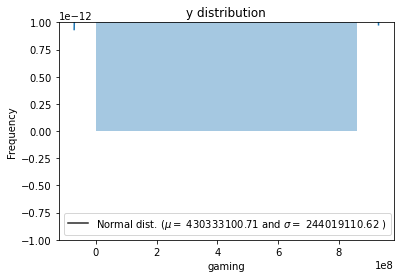

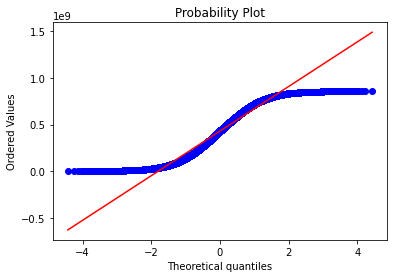

In [43]:
sns.distplot(data['gaming'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['gaming'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['gaming'], plot=plt)
plt.show()


 mu = 22628606.54 and sigma = 9260789.22



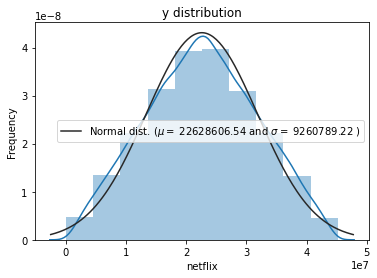

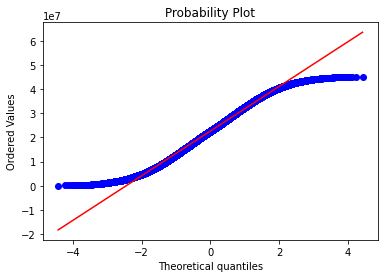

In [44]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
sns.distplot(data['netflix'] , bins = 10, fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['netflix'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['netflix'], plot=plt)
plt.show()


 mu = 22643482.64 and sigma = 9246769.48



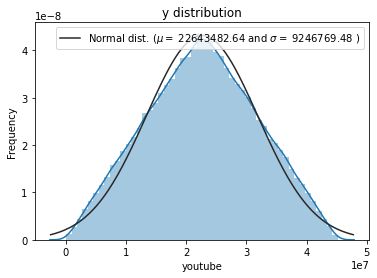

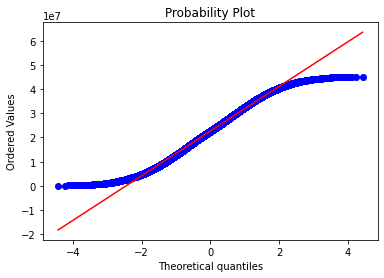

In [45]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
sns.distplot(data['youtube'] , fit=norm);
# sns.violinplot(data['youtube'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['youtube'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['youtube'], plot=plt)
plt.show()


 mu = 2259102.31 and sigma = 1071105.49



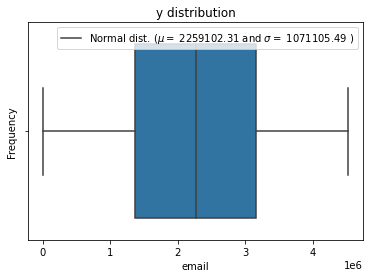

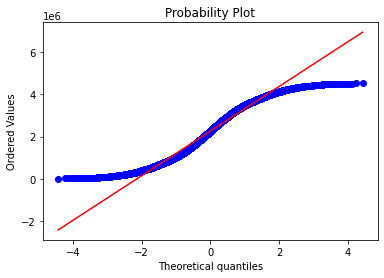

In [46]:
# sns.distplot(data['email'], fit = norm) # numeric
sns.boxplot(data['email'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['email'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['email'], plot=plt)
plt.show()


 mu = 7807294.55 and sigma = 3516408.52



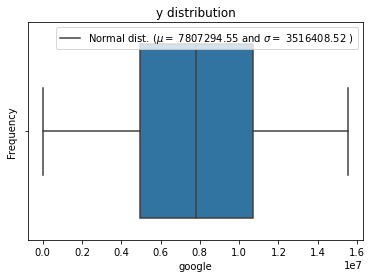

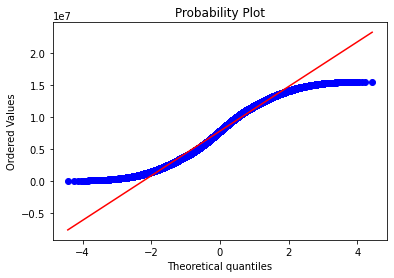

In [47]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
# sns.distplot(data['google'] , fit=norm);
sns.boxplot(data['google'])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['google'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['google'], plot=plt)
plt.show()


 mu = 1828250.21 and sigma = 1035642.69



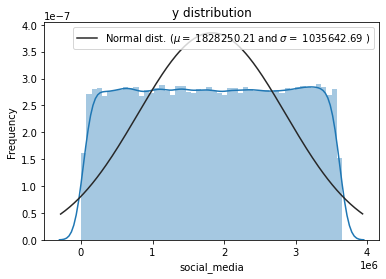

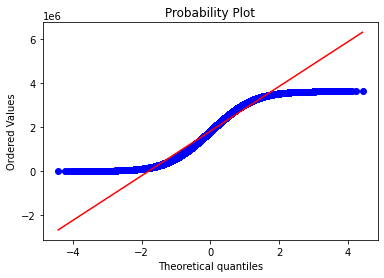

In [48]:
# sns.distplot(data['Social Media DL (Bytes)']) # numeric
sns.distplot(data['social_media'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['social_media'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['social_media'], plot=plt)
plt.show()


 mu = 495764636.37 and sigma = 244380172.44



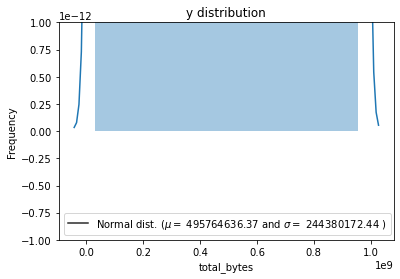

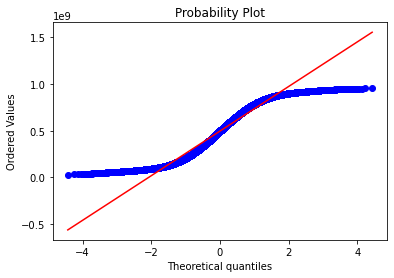

In [52]:
# total upload and download bytes
sns.distplot(data['total_bytes'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['total_bytes'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['total_bytes'], plot=plt)
plt.show()


 mu = 104609105.55 and sigma = 81037071.33



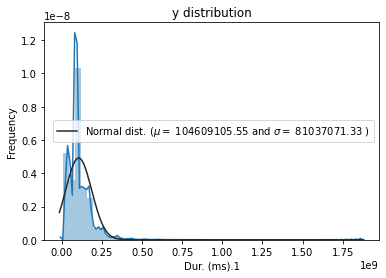

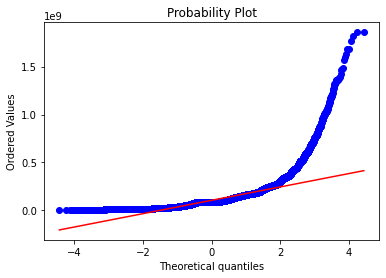

In [55]:
# xdr ms
sns.distplot(data['Dur. (ms).1'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data['Dur. (ms).1'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data['Dur. (ms).1'], plot=plt)
plt.show()

Heavily rightly skewed.

## Bivariate Analysis
– explore the relationship between each application & the total DL+UL data using appropriate methods and interpret your findings.

(Social Media, Google, Email, YouTube, Netflix, Gaming ++ total_bytes).

In [57]:
# data['total'] = data['Total DL (Bytes)'] + data['Total UL (Bytes)']
# sns.barplot(x = data['social_media'], y = data['total'])

biv_data = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'total_bytes', 'other']]
# adding a summation row in all columns
biv_data.loc['totals'] = biv_data.sum()
biv_data.tail()

,social_media,google,email,youtube,netflix,gaming,total_bytes,other
149997,2.352181e+06,4.415361e+06,2.121718e+06,2.216552e+07,4.064329e+07,6.316281e+08,7.057839e+08,7.146381e+08
149998,1.260239e+06,6.585469e+06,2.058277e+06,2.451641e+07,1.502970e+07,5.669338e+08,6.276986e+08,1.324156e+08
149999,8.231090e+05,7.757267e+06,2.850914e+06,1.712251e+07,1.649484e+07,3.550664e+08,4.015220e+08,8.161200e+08
150000,1.828250e+06,7.807295e+06,2.259102e+06,2.264348e+07,2.262861e+07,4.303331e+08,4.957646e+08,4.293653e+08
totals,2.742394e+11,1.171102e+12,3.388676e+11,3.396545e+12,3.394314e+12,6.455040e+13,7.436519e+13,6.440523e+13


### Applications total bytes

Text(0.5, 0, 'application')

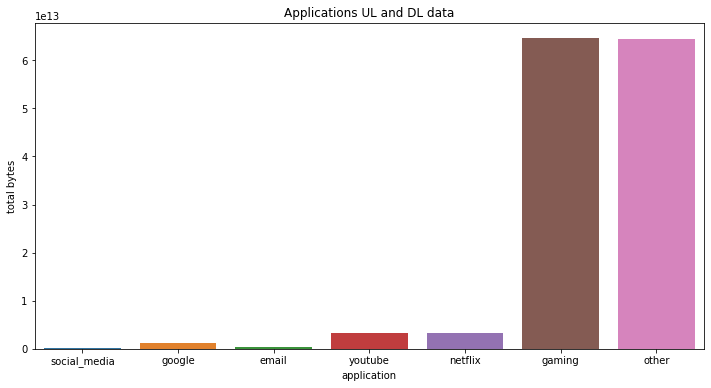

In [58]:
a = biv_data.tail(1)
long_df = pd.melt(a)
long_df = long_df.drop([6], axis  = 0)
plt.figure(figsize=(12,6))
sns.barplot(x = long_df.variable, y = long_df.value)
plt.title('Applications UL and DL data')
plt.ylabel('total bytes')
plt.xlabel('application')

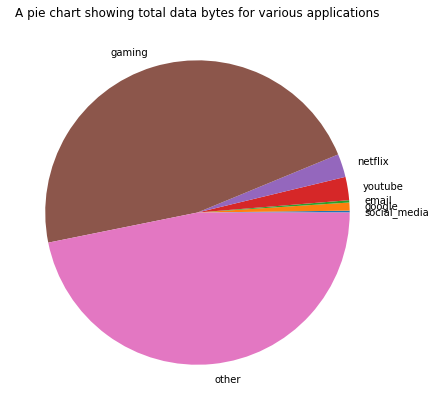

In [61]:
fig = plt.figure(figsize =(10, 7)) 
a = biv_data.drop(['total_bytes'], axis = 1)
plt.pie(a.loc['totals'], labels = a.columns)
plt.title('A pie chart showing total data bytes for various applications')
plt.show()



Will you look at that!!!
Gamers Republic!!
*  The large percentage of **others** can be explained by many applications under the name others.
*  As for gaming:
  1. The applications are heavy. (Require more data)
  2. Most of the users are gamers.
  3. Most of the applications in the hand sets are games.

## Variable transformations
– segment the users into top five decile classes based on the total duration for all sessions and compute the total data (DL+UL) per decile class.

In [67]:
# adding Decile_rank column to the DataFrame 
data['Decile_rank'] = pd.qcut(data['Dur. (ms)'], 5, labels = False) 
data.columns

Index(['Start ms', 'End ms', 'Dur. (ms)', 'IMSI', 'MSISDN/Number', 'IMEI',
       'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
       'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)',
       'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)',
       '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)',
       'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)',
       '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)',
       'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1',
       'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',
       'Nb of sec with Vol DL < 6250B', 'Nb of sec with Vol UL < 1250B',
       'Social Media DL (

In [68]:
new_df = data[['Decile_rank', 'total_bytes']]
a = new_df.groupby('Decile_rank').sum()
a

,total_bytes
Decile_rank,
0,1.488404e+13
1,2.361997e+13
2,6.089083e+12
3,1.485375e+13
4,1.491834e+13


Text(0.5, 0, 'decile rank')

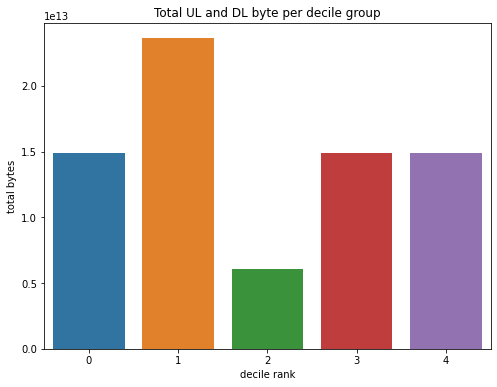

In [69]:
plt.figure(figsize=(8,6))
sns.barplot(x = a.index, y = a.total_bytes)
plt.title('Total UL and DL byte per decile group')
plt.ylabel('total bytes')
plt.xlabel('decile rank')

## Correlation Analysis
– compute a correlation matrix for the following variables and interpret your findings: Social Media data, Google data, Email data, Youtube data, Netflix data, Gaming data, Other data - (jupyter notebook + slide )

### correlation on the total bytes

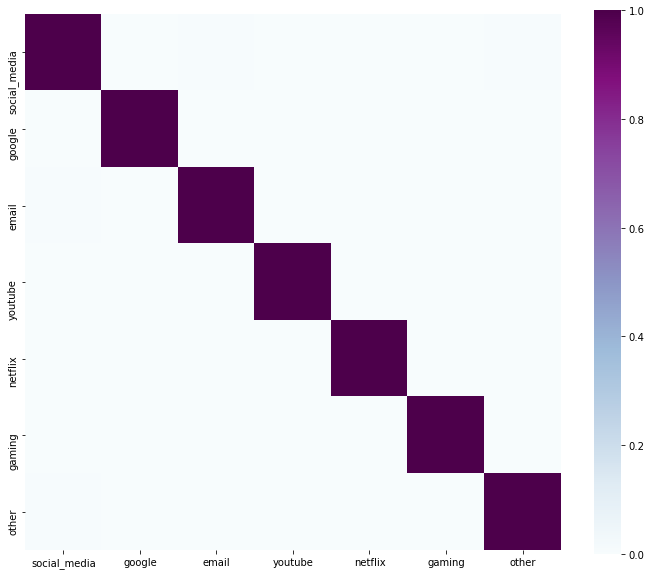

In [70]:
corr_data = data[['social_media', 'google', 'email', 'youtube', 'netflix', 'gaming', 'other']]

    
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(12, 10))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

##### The correlation between the variables is super low. 

### On the upload bytes

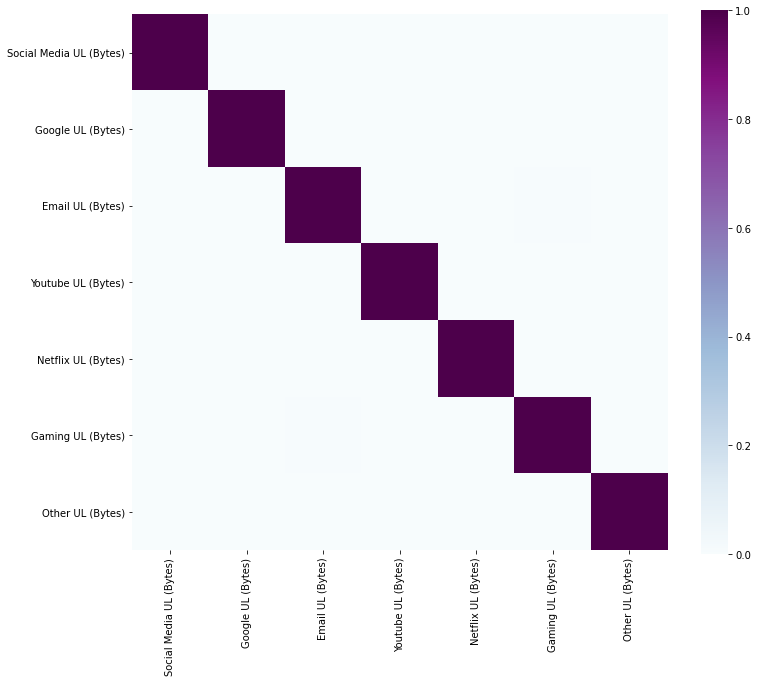

In [71]:
corr_data = data[['Social Media UL (Bytes)', 'Google UL (Bytes)', 'Email UL (Bytes)', 'Youtube UL (Bytes)', 'Netflix UL (Bytes)', 'Gaming UL (Bytes)', 'Other UL (Bytes)']]

    
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(12, 10))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

##### The correlation between the variables is super low. 

### On the download bytes

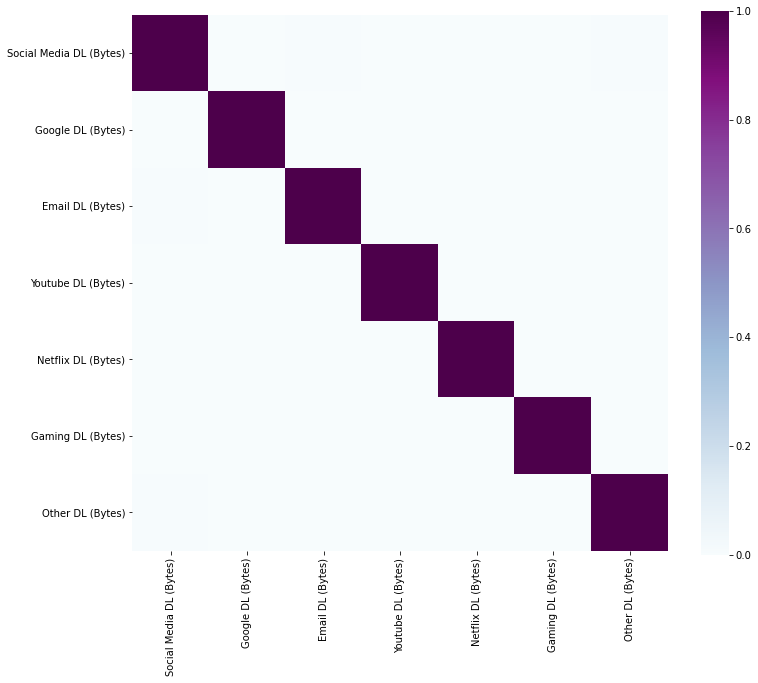

In [72]:
corr_data = data[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']]

    
corr = corr_data.corr()
f_fig, f_ax = plt.subplots(figsize=(12, 10))
f_ax = sns.heatmap(corr, vmin=0, vmax=1, square=True,
                   annot=False, annot_kws={"size": 10}, cmap="BuPu")

##### The correlation between the variables is super low. 

## Dimensionality Reduction
– perform a principal component analysis to reduce the dimensions of your data and provide a useful interpretation of the results.

In [73]:
# standardize the data
from sklearn.preprocessing import StandardScaler


new_numerical = [] #this leaves out the categorical columns that were encoded but not replaced
for col in data.columns:
    if data[col].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        new_numerical.append(col)
        
seg = data[new_numerical].copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(seg)

In [ ]:
# pd.DataFrame(scaled_data)

In [74]:
scaled_data.shape

(150001, 62)

In [75]:
pca = PCA()
pca.fit(scaled_data)

PCA()

In [76]:
pca.explained_variance_ratio_

array([1.23660509e-01, 6.45021861e-02, 5.08683407e-02, 4.60926309e-02,
       4.11019800e-02, 3.38728946e-02, 3.25387682e-02, 3.24579954e-02,
       3.22696539e-02, 3.20777591e-02, 3.18877804e-02, 2.88852046e-02,
       2.75921319e-02, 2.55404031e-02, 2.36567205e-02, 2.34941928e-02,
       2.27051098e-02, 1.84699904e-02, 1.80877131e-02, 1.79189295e-02,
       1.63252018e-02, 1.61882726e-02, 1.61690374e-02, 1.61178750e-02,
       1.60846091e-02, 1.59963839e-02, 1.59563673e-02, 1.57559839e-02,
       1.50924248e-02, 1.41653544e-02, 1.24692113e-02, 1.17837092e-02,
       1.15300358e-02, 1.09754349e-02, 9.81626274e-03, 8.56858948e-03,
       8.35542217e-03, 7.65201683e-03, 6.15957038e-03, 5.51437865e-03,
       4.62384704e-03, 4.60973848e-03, 4.36143301e-03, 2.84444775e-03,
       2.47265327e-03, 1.29969998e-03, 1.02363293e-03, 2.66603614e-04,
       6.94933376e-05, 5.70810640e-05, 1.43339109e-05, 1.19033690e-13,
       5.33855418e-32, 4.75023529e-32, 3.16979021e-32, 1.47024637e-32,
      

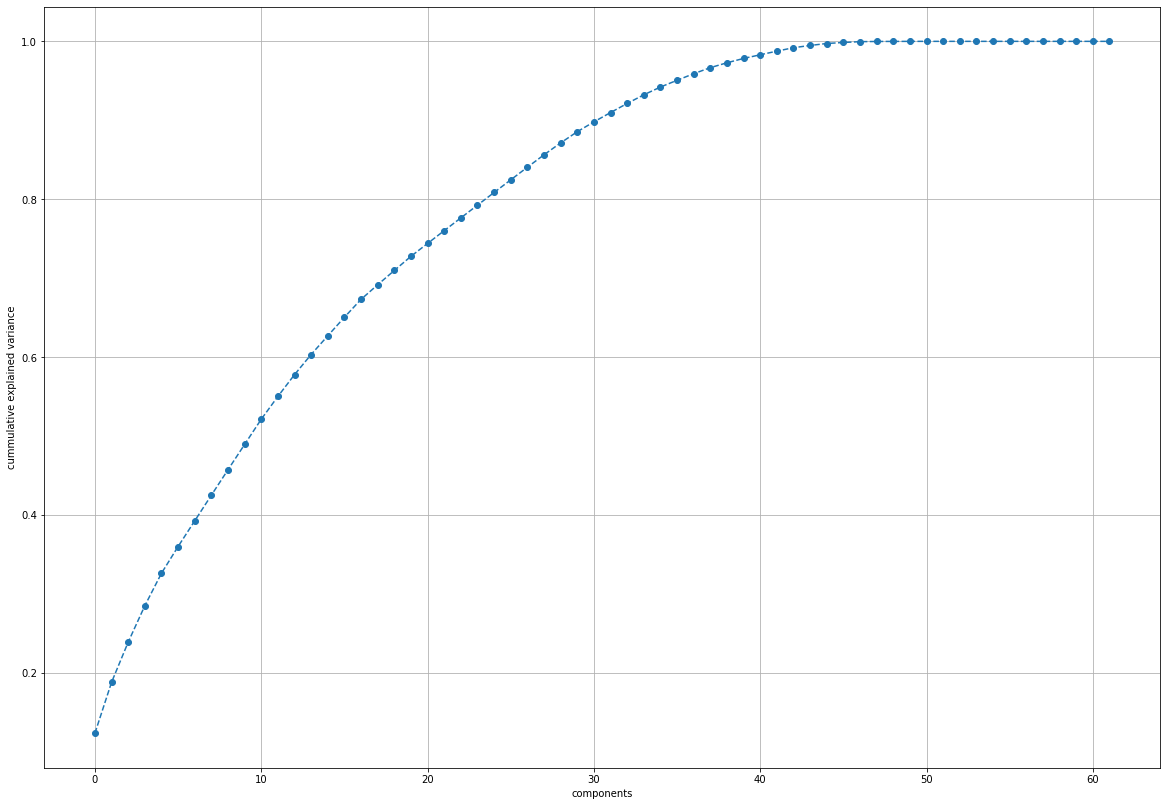

In [78]:
plt.figure(figsize = (20,14))
plt.plot(range(62), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')
plt.grid(True)

When choosing the number of components, the number cutting at least 80% of the cumm explained variance is considered.
**n = 23**

In [79]:
pca = PCA(n_components = 23)
pca.fit(scaled_data)

PCA(n_components=23)

In [80]:
pca_scores = pca.transform(scaled_data)

In [81]:
new_data_df = pd.concat([seg.reset_index(drop = True), pd.DataFrame(pca_scores)], axis = 1)
# c.columns.values[-2:] = ['component1', 'component2']
new_data_df.head() #contains the original cols 


,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),...,13,14,15,16,17,18,19,20,21,22
0,770.0,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,42.000000,5.000000,23.0,44.0,...,-7.158718,-1.270538,0.929845,4.099119,-0.935838,0.778916,-2.582287,0.509379,0.150102,-0.052859
1,235.0,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.000000,5.000000,16.0,26.0,...,-5.182390,-0.787305,-1.057992,2.886197,-1.287938,2.102908,-2.426801,1.446446,-0.545702,1.847457
2,1.0,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,109.795706,17.662883,6.0,9.0,...,-5.277166,-0.686343,-2.479395,2.847407,-1.366067,1.718312,-1.127238,0.915471,-0.457144,0.056328
3,486.0,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,109.795706,17.662883,44.0,44.0,...,-4.458242,-0.720596,-0.175555,2.739067,-1.325782,2.309096,-1.690187,0.370715,-0.269285,0.140056
4,565.0,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,109.795706,17.662883,6.0,9.0,...,-3.874125,-0.600639,-0.640816,2.202136,-0.391758,0.275765,-2.499894,2.346298,-1.057806,-0.221877


## 2. User Engagement analysis

[Back to top](#Libraries)